# HW3 — Federated Learning & Differential Privacy (FL + DP)

This notebook combines all code for:
- **Part 1**: Federated Learning (FedAvg) - Serial and Ray-based implementations
- **Part 2**: Differential Privacy with Laplace Noise

## Table of Contents
1. Setup and Imports
2. Helper Functions (Data Loading, Preprocessing)
3. Model Definition
4. **Part 1: Federated Learning (FedAvg)**
   - 4.1 Serial FedAvg Implementation
   - 4.2 Ray-based Parallel FedAvg (Optional)
   - 4.3 Plotting Utilities
5. **Part 2: Differential Privacy**
   - 5.1 Laplace Noise Implementation
   - 5.2 DP Experiments
   - 5.3 Privacy-Utility Tradeoff Analysis


Name: Victor Olawale-Apanpa

DATE: 19 NOV 2025

 - Github Username: vapanpa
  - How to Run: Notebook should be in the same directory as 'HW3-data' folder.

 Run as is to produce output folders 'output/part1' and 'output/part2' with all required plots.

## 1. Setup and Imports


In [1]:
import os
import sys
import math
import random
import csv
import json
from typing import List, Tuple, Dict
from pathlib import Path
from collections import defaultdict

import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from scipy.stats import laplace

# Optional: Ray for parallel federated learning
try:
    import ray
    RAY_AVAILABLE = True
except ImportError:
    RAY_AVAILABLE = False
    print("Ray not available. Parallel FedAvg will be disabled.")

# Set random seeds for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)

# Configuration
class Config:
    # Data paths
    train_data_path = "HW3-data/Assignment3-data/train_data.npy"
    test_data_path = "HW3-data/Assignment3-data/test_data.npy"
    
    # Federated Learning hyperparameters
    rounds = 50
    client_frac = 0.1
    local_epochs = 1
    batch_size = 64
    lr = 1e-3
    optimizer = "adam"  # "sgd", "adam", "adamw"
    weight_decay = 0.0
    label_smoothing = 0.0
    
    # Model architecture
    hidden_layers = [256, 128]
    dropout = 0.0
    use_bn = False
    standardize = True
    
    # Differential Privacy
    noise_scales = [0.0, 0.01, 0.05, 0.1]  # Laplace scale parameter b
    
    # Output directories
    output_dir = "output"
    part1_dir = "output/part1"
    part2_dir = "output/part2"
    
    # Device
    use_gpu = torch.cuda.is_available()
    
# Create output directories
os.makedirs(Config.part1_dir, exist_ok=True)
os.makedirs(Config.part2_dir, exist_ok=True)

print(f"Device: {'CUDA' if Config.use_gpu else 'CPU'}")
print(f"Ray available: {RAY_AVAILABLE}")


/Users/victorapanpa/Documents/Learning/MachineLearning-DeepLearning-DS_Coding/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-11-19 13:41:02,342	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


Device: CPU
Ray available: True


## 2. Helper Functions (Data Loading & Preprocessing)


In [2]:
# -------------------------
# Data Loading Helpers
# -------------------------

def _as_ndarray(x):
    return x if isinstance(x, np.ndarray) else np.asarray(x)

def _unwrap_object_array(a):
    if isinstance(a, np.ndarray) and a.dtype == object and a.shape == (1,):
        try: 
            return a.item()
        except Exception: 
            return a
    return a

def _maybe_item(x):
    if isinstance(x, np.ndarray) and x.dtype == object and x.shape == ():
        try: 
            return x.item()
        except Exception: 
            return x
    return x

def _xy_from_obj(obj) -> Tuple[np.ndarray, np.ndarray]:
    """Extract X and y from various container types."""
    obj = _maybe_item(obj)
    if isinstance(obj, dict):
        kx = next((k for k in obj.keys() if k.lower() in ("images","image","x","data","features")), None)
        ky = next((k for k in obj.keys() if k.lower() in ("labels","label","y","target","targets")), None)
        if kx is None or ky is None: 
            raise ValueError("Dict missing image/label keys.")
        return _as_ndarray(obj[kx]), _as_ndarray(obj[ky])
    if isinstance(obj, (list, tuple)) and len(obj) == 2:
        X, y = obj
        return _as_ndarray(X), _as_ndarray(y)
    raise ValueError("Unknown (X,y) container.")

def _flatten2d(X: np.ndarray) -> np.ndarray:
    """Flatten images to 2D if needed."""
    return X.reshape(X.shape[0], -1) if X.ndim > 2 else X

def _cfloat32(a: np.ndarray) -> np.ndarray:
    """Convert to contiguous float32 array."""
    return np.ascontiguousarray(a.astype(np.float32, copy=False))

def load_clients_from_npy(train_path: str) -> List[Tuple[np.ndarray, np.ndarray]]:
    """Load federated client data from .npy file."""
    a = np.load(train_path, allow_pickle=True)
    a = _unwrap_object_array(a)

    if isinstance(a, np.ndarray) and a.dtype == object and a.ndim == 1 and a.size > 1:
        clients = []
        for i in range(a.size):
            Xi, yi = _xy_from_obj(a[i])
            # Normalize images to [0, 1] if needed
            if Xi.max() > 1.0:
                Xi = Xi / 255.0
            clients.append((Xi, yi))
        return clients

    # Fallback: monolithic data, split into clients
    X, y = _xy_from_obj(a)
    if X.max() > 1.0:
        X = X / 255.0
    return split_into_clients(X, y, n_clients=100, seed=42)

def load_test_from_npy(test_path: str) -> Tuple[np.ndarray, np.ndarray]:
    """Load test data from .npy file."""
    b = np.load(test_path, allow_pickle=True)
    b = _unwrap_object_array(b)
    Xte, yte = _xy_from_obj(b)
    # Normalize images to [0, 1] if needed
    if Xte.max() > 1.0:
        Xte = Xte / 255.0
    return Xte, yte

def split_into_clients(X: np.ndarray, y: np.ndarray, n_clients: int, seed: int = 42):
    """Split monolithic data into n_clients shards."""
    rng = np.random.default_rng(seed)
    idx = np.arange(len(y))
    rng.shuffle(idx)
    shards = np.array_split(idx, n_clients)
    return [(X[s], y[s]) for s in shards]

def remap_labels_global(clients: List[Tuple[np.ndarray, np.ndarray]], test_y: np.ndarray):
    """Remap labels to consecutive integers starting from 0."""
    ys = [c[1].ravel() for c in clients if len(c[1]) > 0]
    ys.append(test_y.ravel())
    all_y = np.concatenate(ys)

    if all_y.dtype.kind in "fc": 
        all_y = np.rint(all_y).astype(np.int64)
    uniq = np.unique(all_y)
    label2new = {int(lbl): i for i, lbl in enumerate(uniq.tolist())}

    def _remap(y):
        y = np.rint(y).astype(np.int64) if y.dtype.kind in "fc" else y.astype(np.int64, copy=False)
        return np.vectorize(lambda t: label2new[int(t)])(y)

    new_clients = [(X, _remap(y)) for (X, y) in clients]
    test_y_new = _remap(test_y)
    K = len(uniq)
    return new_clients, test_y_new, K, label2new

def standardize_train_test(clients, Xte):
    """Standardize features using training data statistics."""
    Xs = [_flatten2d(c[0]) for c in clients if len(c[1]) > 0]
    bigX = np.concatenate(Xs, axis=0)
    mean = bigX.mean(axis=0)
    std = bigX.std(axis=0)
    std[std == 0] = 1.0
    new_clients = []
    for Xc, yc in clients:
        X2 = _flatten2d(Xc)
        X2 = _cfloat32((X2 - mean) / std)
        new_clients.append((X2, yc))
    Xte2 = _flatten2d(Xte)
    Xte2 = _cfloat32((Xte2 - mean) / std)
    return new_clients, Xte2

def to_float_clients(clients):
    """Convert client data to float32 without standardization."""
    return [(_cfloat32(_flatten2d(X)), y) for (X, y) in clients]

def to_float_test(Xte):
    """Convert test data to float32 without standardization."""
    return _cfloat32(_flatten2d(Xte))

print("Data loading functions defined.")


Data loading functions defined.


In [3]:
# -------------------------
# Model: Multi-Layer Perceptron (MLP)
# -------------------------

class MLP(nn.Module):
    def __init__(self, in_dim: int, hidden: List[int], out_dim: int, dropout: float = 0.0, use_bn: bool = False):
        super().__init__()
        layers = []
        last = in_dim
        for h in hidden:
            layers.append(nn.Linear(last, h))
            if use_bn: 
                layers.append(nn.BatchNorm1d(h))
            layers.append(nn.ReLU(inplace=True))
            if dropout and dropout > 0: 
                layers.append(nn.Dropout(dropout))
            last = h
        layers.append(nn.Linear(last, out_dim))
        self.net = nn.Sequential(*layers)
    
    def forward(self, x): 
        return self.net(x)

print("MLP model defined.")


MLP model defined.


## 4. Part 1: Federated Learning (FedAvg)

### 4.1 Serial FedAvg Implementation


In [4]:
# -------------------------
# Dataset and DataLoader
# -------------------------

class NumpyDataset(Dataset):
    def __init__(self, X, y):
        self.X = _cfloat32(_as_ndarray(X))
        self.y = _as_ndarray(y).astype(np.int64, copy=False)
        assert len(self.X) == len(self.y)
    
    def __len__(self): 
        return len(self.y)
    
    def __getitem__(self, i): 
        return self.X[i], self.y[i]

def make_loader(X, y, bs, shuffle=True, drop_last=False):
    if len(y) == 0:
        Xd = np.zeros((0, X.shape[1]), dtype=np.float32)
        yd = np.zeros((0,), dtype=np.int64)
        return DataLoader(NumpyDataset(Xd, yd), batch_size=bs, shuffle=False, drop_last=False)
    return DataLoader(NumpyDataset(X, y), batch_size=bs, shuffle=shuffle, drop_last=drop_last)


In [5]:
# -------------------------
# Local Training Function
# -------------------------

def local_train(global_state, model_ctor, X, y, local_epochs, lr, optimizer_type, weight_decay, 
                label_smoothing, batch_size, use_bn, device):
    """Train model locally on client data."""
    if len(y) == 0: 
        return None
    
    model = model_ctor().to(device)
    model.load_state_dict(global_state, strict=True)

    if optimizer_type == "sgd":
        opt = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=weight_decay)
    elif optimizer_type == "adam":
        opt = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    else:
        opt = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

    ce = nn.CrossEntropyLoss(label_smoothing=label_smoothing) if label_smoothing > 0 else nn.CrossEntropyLoss()
    loader = make_loader(X, y, batch_size, shuffle=True, drop_last=use_bn)

    model.train()
    for _ in range(local_epochs):
        for xb, yb in loader:
            # BN-safe: skip pathological 1-sample batch
            if use_bn and xb.size(0) == 1:
                continue
            xb = xb.to(device, non_blocking=True)
            yb = yb.to(device, non_blocking=True)
            logits = model(xb)
            loss = ce(logits, yb)
            opt.zero_grad(set_to_none=True)
            loss.backward()
            opt.step()

    st = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
    return (st, len(y))


In [6]:
# -------------------------
# Evaluation Functions
# -------------------------

@torch.no_grad()
def evaluate(model, Xte, yte, bs, device):
    """Evaluate model on test data."""
    model.eval()
    loader = make_loader(Xte, yte, bs, shuffle=False, drop_last=False)
    n, correct, total_loss = 0, 0, 0.0
    ce = nn.CrossEntropyLoss(reduction="sum")
    for xb, yb in loader:
        xb = xb.to(device)
        yb = yb.to(device)
        logits = model(xb)
        total_loss += ce(logits, yb).item()
        preds = logits.argmax(dim=1)
        correct += (preds == yb).sum().item()
        n += len(yb)
    if n == 0: 
        return 0.0, float("nan")
    return correct / n, total_loss / n

@torch.no_grad()
def evaluate_on_clients(model, clients, bs, device):
    """Evaluate model on union of all client training data."""
    model.eval()
    Xs = [c[0] for c in clients if len(c[1]) > 0]
    ys = [c[1] for c in clients if len(c[1]) > 0]
    if not Xs: 
        return 0.0, float("nan")
    X_all = np.concatenate(Xs, axis=0)
    y_all = np.concatenate(ys, axis=0)
    acc, loss = evaluate(model, X_all, y_all, bs, device)
    return acc, loss


In [7]:
# -------------------------
# FedAvg Aggregation
# -------------------------

def weighted_average_states(collected: List[Tuple[Dict[str, torch.Tensor], int]]):
    """Weighted average of model states by sample count."""
    total = sum(n for _, n in collected)
    base = {k: v.clone() for k, v in collected[0][0].items()}
    for k in base.keys():
        if torch.is_floating_point(base[k]):
            base[k].mul_(collected[0][1] / total)
            for st, n_i in collected[1:]:
                base[k].add_(st[k] * (n_i / total))
        else:
            base[k] = collected[0][0][k]
    return base


In [8]:
# -------------------------
# Main FedAvg Training Loop
# -------------------------

def train_fedavg_serial(
    clients, Xte, yte, n_classes, in_dim,
    rounds=50, client_frac=0.1, local_epochs=1, batch_size=64, lr=1e-3,
    optimizer="adam", weight_decay=0.0, label_smoothing=0.0,
    hidden=[256, 128], dropout=0.0, use_bn=False,
    device=None, seed=42, noise_scale=0.0
):
    """
    Train federated model using serial FedAvg.
    
    Parameters:
    -----------
    noise_scale : float
        Laplace noise scale b for DP (0 = no noise). Applied to client data.
    """
    if device is None:
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    
    set_seed(seed)
    
    # Apply Laplace noise if specified (for Part 2)
    if noise_scale > 0.0:
        print(f"Applying Laplace noise with scale b={noise_scale} to all clients")
        for i in range(len(clients)):
            Xc, yc = clients[i]
            noise = laplace.rvs(loc=0.0, scale=noise_scale, size=Xc.shape)
            Xc_noisy = np.clip(Xc + noise, 0.0, 1.0)
            clients[i] = (Xc_noisy, yc)
    
    def model_ctor():
        return MLP(in_dim=in_dim, hidden=hidden, out_dim=n_classes, dropout=dropout, use_bn=use_bn)

    global_model = model_ctor()
    global_state = {k: v.detach().cpu().clone() for k, v in global_model.state_dict().items()}

    best_acc = -1.0
    history = []

    for rnd in range(1, rounds + 1):
        # Select clients for this round
        m = max(1, int(math.ceil(client_frac * len(clients))))
        sel = np.random.choice(len(clients), size=m, replace=False)
        collected = []
        
        for idx in sel:
            Xc, yc = clients[idx]
            if len(yc) == 0: 
                continue
            res = local_train(
                global_state, model_ctor, Xc, yc, local_epochs, lr, optimizer, 
                weight_decay, label_smoothing, batch_size, use_bn, device
            )
            if res is not None: 
                collected.append(res)
        
        if not collected: 
            continue

        # Aggregate updates
        global_state = weighted_average_states(collected)
        global_model.load_state_dict(global_state, strict=True)

        # Evaluate
        train_acc, train_loss = evaluate_on_clients(global_model.to(device), clients, bs=1024, device=device)
        test_acc, test_loss = evaluate(global_model.to(device), Xte, yte, bs=1024, device=device)
        
        print(f"[Round {rnd:03d}] train_acc={train_acc:.4f} test_acc={test_acc:.4f} loss={test_loss:.4f}")
        
        history.append({
            "round": rnd,
            "train_acc": train_acc,
            "test_acc": test_acc,
            "loss": test_loss
        })
        
        if test_acc > best_acc:
            best_acc = test_acc

    print(f"Done. Best acc={best_acc:.4f}")
    return history, global_state, best_acc


### 4.2 Example: Run Part 1 (Serial FedAvg)


In [9]:
# Load data
print("Loading data...")
clients = load_clients_from_npy(Config.train_data_path)
Xte, yte = load_test_from_npy(Config.test_data_path)

# Preprocess
clients, yte, n_classes, label_map = remap_labels_global(clients, yte)
print(f"Number of classes: {n_classes}")

if Config.standardize:
    clients, Xte = standardize_train_test(clients, Xte)
    print("Data standardized.")
else:
    clients = to_float_clients(clients)
    Xte = to_float_test(Xte)
    print("Data converted to float32.")

# Get input dimension
sizes = [len(c[1]) for c in clients]
n_total = int(sum(sizes))
in_dim = clients[next(i for i, s in enumerate(sizes) if s > 0)][0].shape[1] if any(s > 0 for s in sizes) else Xte.shape[1]

print(f"Clients: {len(clients)} | Total samples: {n_total}")
print(f"Input dimension: {in_dim} | Output classes: {n_classes}")
if sizes:
    print(f"Client sizes: min={min(sizes)} med={int(np.median(sizes))} max={max(sizes)} empties={(np.array(sizes)==0).sum()}")


Loading data...
Number of classes: 62
Data standardized.
Clients: 100 | Total samples: 31825
Input dimension: 784 | Output classes: 62
Client sizes: min=118 med=331 max=393 empties=0


In [10]:
# Run Part 1: Federated Learning (no noise)
device = torch.device("cuda:0" if Config.use_gpu else "cpu")
print(f"\n{'='*60}")
print("Part 1: Federated Learning (FedAvg) - Serial")
print(f"{'='*60}")

history_part1, global_state_part1, best_acc_part1 = train_fedavg_serial(
    clients=clients,
    Xte=Xte,
    yte=yte,
    n_classes=n_classes,
    in_dim=in_dim,
    rounds=Config.rounds,
    client_frac=Config.client_frac,
    local_epochs=Config.local_epochs,
    batch_size=Config.batch_size,
    lr=Config.lr,
    optimizer=Config.optimizer,
    weight_decay=Config.weight_decay,
    label_smoothing=Config.label_smoothing,
    hidden=Config.hidden_layers,
    dropout=Config.dropout,
    use_bn=Config.use_bn,
    device=device,
    seed=42,
    noise_scale=0.0  # No noise for Part 1
)



Part 1: Federated Learning (FedAvg) - Serial
[Round 001] train_acc=0.0820 test_acc=0.0842 loss=4.1060
[Round 002] train_acc=0.1513 test_acc=0.1563 loss=3.9805
[Round 003] train_acc=0.1360 test_acc=0.1397 loss=3.7770
[Round 004] train_acc=0.1613 test_acc=0.1743 loss=3.4912
[Round 005] train_acc=0.1921 test_acc=0.2157 loss=3.2660
[Round 006] train_acc=0.2827 test_acc=0.3088 loss=3.1021
[Round 007] train_acc=0.3002 test_acc=0.3192 loss=2.9643
[Round 008] train_acc=0.3451 test_acc=0.3607 loss=2.8641
[Round 009] train_acc=0.3508 test_acc=0.3676 loss=2.7449
[Round 010] train_acc=0.4036 test_acc=0.4159 loss=2.6527
[Round 011] train_acc=0.4178 test_acc=0.4319 loss=2.5653
[Round 012] train_acc=0.4011 test_acc=0.4126 loss=2.5074
[Round 013] train_acc=0.4436 test_acc=0.4502 loss=2.4184
[Round 014] train_acc=0.4441 test_acc=0.4502 loss=2.3610
[Round 015] train_acc=0.4541 test_acc=0.4609 loss=2.3150
[Round 016] train_acc=0.4774 test_acc=0.4841 loss=2.2491
[Round 017] train_acc=0.4981 test_acc=0.50

### 4.3 Plotting Utilities for Part 1


Saved: output/part1/part1_cf0.100_e1_acc.png


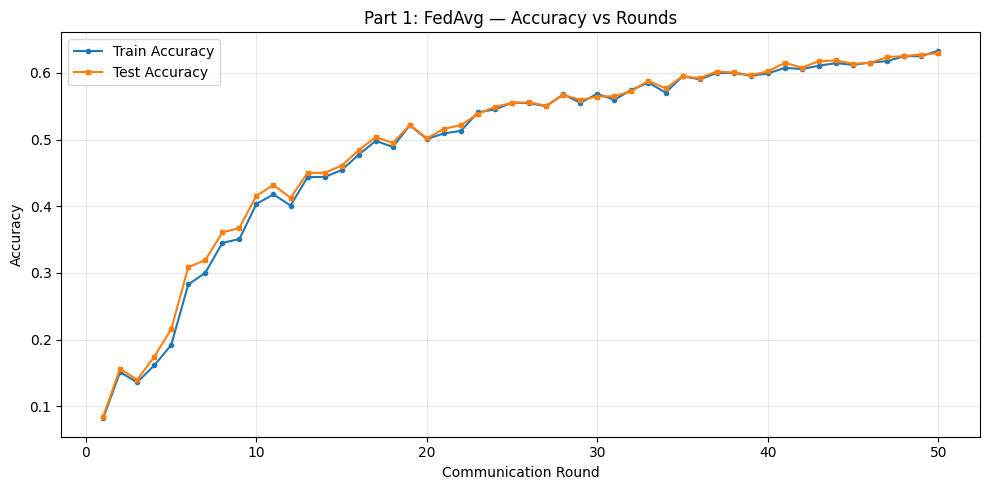

Saved: output/part1/part1_cf0.100_e1_loss.png


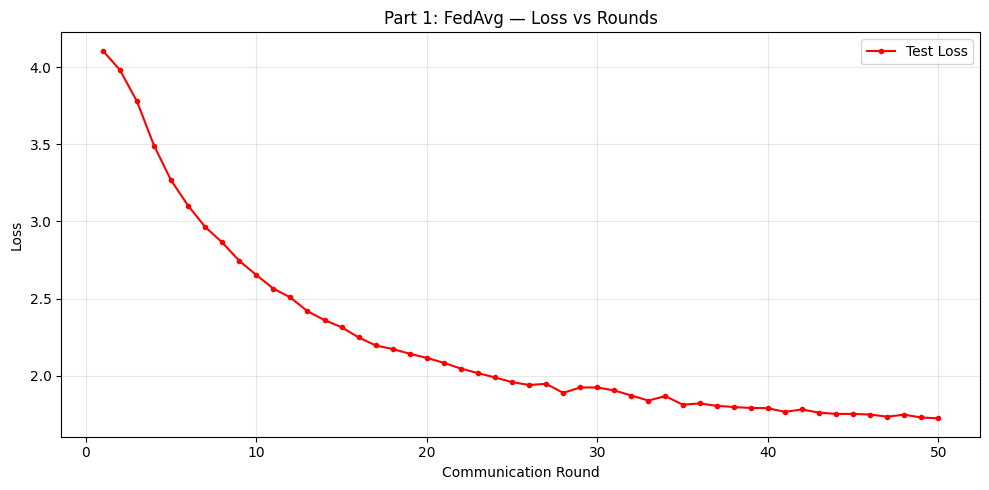

Saved: output/part1/part1_global_label_hist.png


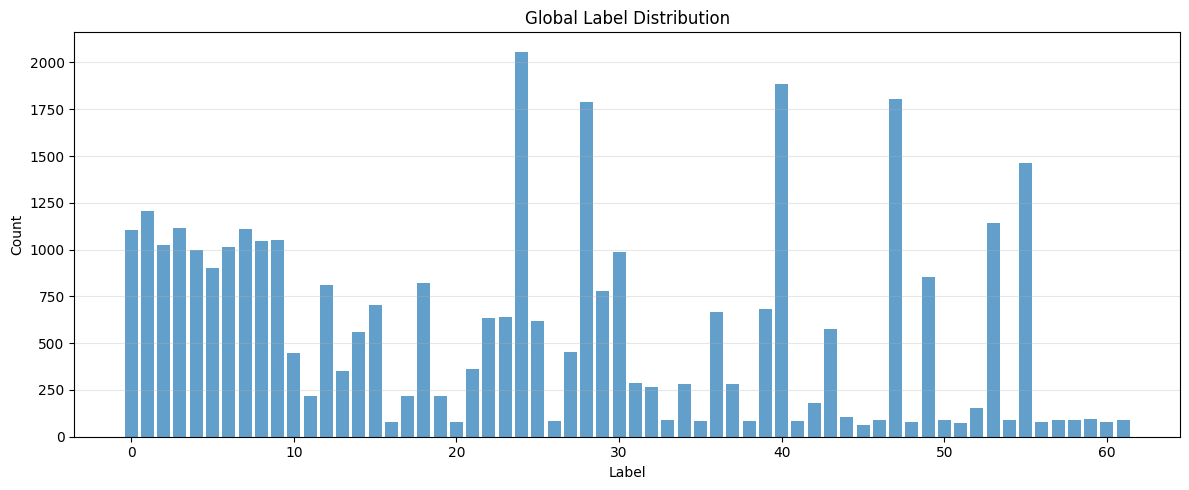

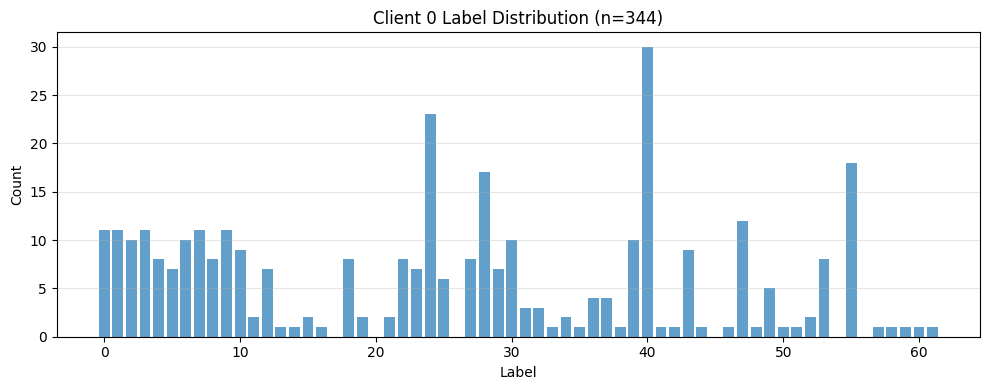

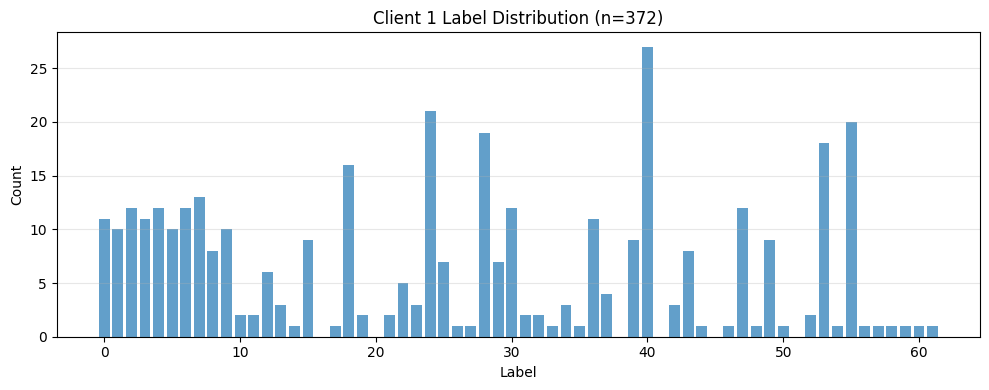

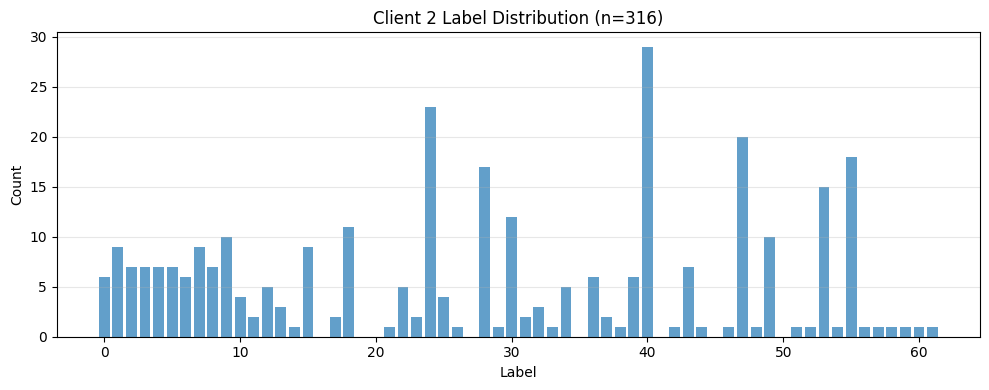

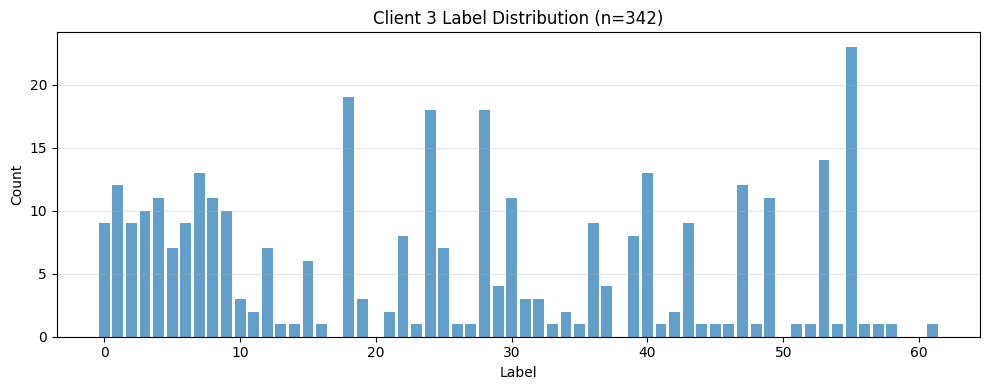

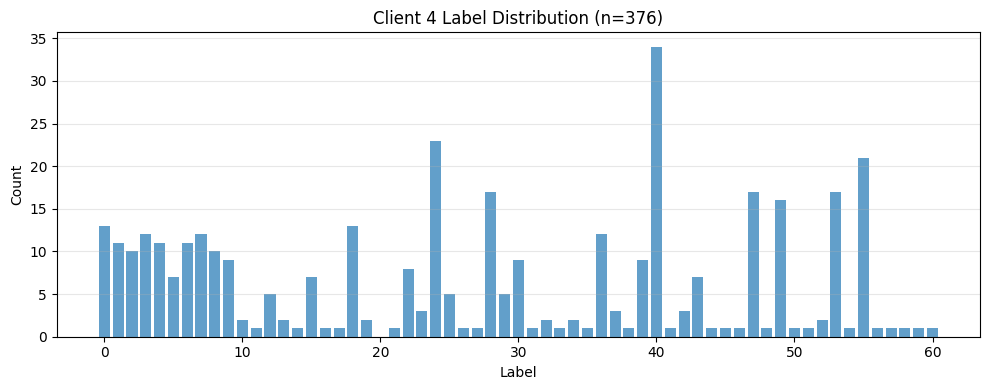

In [11]:
# -------------------------
# Plotting Functions
# -------------------------

def plot_training_history(history, title_prefix="Part 1", save_path=None):
    """Plot accuracy and loss vs communication rounds."""
    rounds = [h["round"] for h in history]
    train_accs = [h["train_acc"] for h in history]
    test_accs = [h["test_acc"] for h in history]
    losses = [h["loss"] for h in history]
    
    # Accuracy plot
    plt.figure(figsize=(10, 5))
    plt.plot(rounds, train_accs, label='Train Accuracy', marker='o', markersize=3)
    plt.plot(rounds, test_accs, label='Test Accuracy', marker='s', markersize=3)
    plt.xlabel('Communication Round')
    plt.ylabel('Accuracy')
    plt.title(f'{title_prefix} — Accuracy vs Rounds')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    if save_path:
        plt.savefig(f"{save_path}_acc.png", dpi=160, bbox_inches="tight")
        print(f"Saved: {save_path}_acc.png")
    plt.show()
    
    # Loss plot
    plt.figure(figsize=(10, 5))
    plt.plot(rounds, losses, label='Test Loss', marker='o', markersize=3, color='red')
    plt.xlabel('Communication Round')
    plt.ylabel('Loss')
    plt.title(f'{title_prefix} — Loss vs Rounds')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    if save_path:
        plt.savefig(f"{save_path}_loss.png", dpi=160, bbox_inches="tight")
        print(f"Saved: {save_path}_loss.png")
    plt.show()

def plot_label_histograms(clients, yte, save_dir=None, num_clients_to_plot=5):
    """Plot label distributions for global and selected clients."""
    # Global label histogram
    all_labels = np.concatenate([c[1] for c in clients] + [yte])
    unique_labels, counts = np.unique(all_labels, return_counts=True)
    
    plt.figure(figsize=(12, 5))
    plt.bar(unique_labels, counts, alpha=0.7)
    plt.xlabel('Label')
    plt.ylabel('Count')
    plt.title('Global Label Distribution')
    plt.grid(True, alpha=0.3, axis='y')
    plt.tight_layout()
    if save_dir:
        plt.savefig(f"{save_dir}/part1_global_label_hist.png", dpi=160, bbox_inches="tight")
        print(f"Saved: {save_dir}/part1_global_label_hist.png")
    plt.show()
    
    # Per-client label histograms
    for i in range(min(num_clients_to_plot, len(clients))):
        if len(clients[i][1]) > 0:
            client_labels = clients[i][1]
            unique, counts = np.unique(client_labels, return_counts=True)
            plt.figure(figsize=(10, 4))
            plt.bar(unique, counts, alpha=0.7)
            plt.xlabel('Label')
            plt.ylabel('Count')
            plt.title(f'Client {i} Label Distribution (n={len(client_labels)})')
            plt.grid(True, alpha=0.3, axis='y')
            plt.tight_layout()
            if save_dir:
                plt.savefig(f"{save_dir}/part1_client_{i}_label_hist.png", dpi=160, bbox_inches="tight")
            plt.show()

# Plot Part 1 results
plot_training_history(history_part1, title_prefix="Part 1: FedAvg", 
                     save_path=f"{Config.part1_dir}/part1_cf{Config.client_frac:.3f}_e{Config.local_epochs}")

plot_label_histograms(clients, yte, save_dir=Config.part1_dir, num_clients_to_plot=5)


### 4.4 Optional: Ray-based Parallel FedAvg

*Note: Requires Ray installation. Skip this section if Ray is not available.*


In [12]:
if RAY_AVAILABLE:
    # Ray-based parallel FedAvg implementation
    @ray.remote
    class ClientTrainer:
        def __init__(self, X, y, cfg):
            self.X = torch.from_numpy(X.copy())
            self.y = torch.from_numpy(y.copy())
            self.cfg = cfg
            self.device = torch.device("cpu")
            self.has_bn = bool(cfg.get("use_bn", False))

        def train(self, global_state):
            cfg = self.cfg
            model = MLP(
                cfg["input_dim"],
                cfg["hidden"],
                cfg["n_classes"],
                dropout=cfg["dropout"],
                use_bn=cfg["use_bn"],
            )
            model.load_state_dict(global_state)
            model.to(self.device)

            if cfg["label_smoothing"] > 0:
                ce = nn.CrossEntropyLoss(label_smoothing=cfg["label_smoothing"])
            else:
                ce = nn.CrossEntropyLoss()

            if cfg["optimizer"] == "sgd":
                opt = torch.optim.SGD(model.parameters(), lr=cfg["lr"], momentum=0.9, 
                                     weight_decay=cfg["weight_decay"])
            elif cfg["optimizer"] == "adam":
                opt = torch.optim.Adam(model.parameters(), lr=cfg["lr"], 
                                      weight_decay=cfg["weight_decay"])
            else:
                opt = torch.optim.AdamW(model.parameters(), lr=cfg["lr"], 
                                      weight_decay=cfg["weight_decay"])

            ds = TensorDataset(self.X, self.y)
            loader = DataLoader(ds, batch_size=cfg["batch_size"], shuffle=True, drop_last=False)

            model.train()
            for _ in range(cfg["local_epochs"]):
                for xb, yb in loader:
                    xb = xb.to(self.device)
                    yb = yb.to(self.device)
                    opt.zero_grad()
                    if self.has_bn and xb.size(0) == 1:
                        model.eval()
                        logits = model(xb)
                        model.train()
                    else:
                        logits = model(xb)
                    loss = ce(logits, yb)
                    loss.backward()
                    opt.step()

            return {k: v.cpu() for k, v in model.state_dict().items()}, int(self.y.shape[0])

    def fedavg_ray(global_state, client_states, client_counts):
        """FedAvg aggregation for Ray."""
        total = float(sum(client_counts))
        new_state = {}
        for k in global_state.keys():
            agg = None
            for st, n in zip(client_states, client_counts):
                w = n / total
                v = st[k].float()
                if agg is None:
                    agg = w * v
                else:
                    agg += w * v
            new_state[k] = agg
        return new_state

    def train_fedavg_ray(clients, Xte, yte, n_classes, in_dim, rounds=50, client_frac=0.1,
                        local_epochs=1, batch_size=64, lr=1e-3, optimizer="adamw",
                        weight_decay=0.0, label_smoothing=0.0, hidden=[256, 128],
                        dropout=0.0, use_bn=False, device=None, seed=42, ray_cpus=None):
        """Train federated model using Ray-based parallel FedAvg."""
        if device is None:
            device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        set_seed(seed)
        
        cfg = dict(
            input_dim=in_dim,
            n_classes=n_classes,
            hidden=hidden,
            dropout=dropout,
            use_bn=use_bn,
            local_epochs=local_epochs,
            batch_size=batch_size,
            lr=lr,
            optimizer=optimizer,
            weight_decay=weight_decay,
            label_smoothing=label_smoothing,
        )
        
        print("Initializing Ray...")
        ray.init(num_cpus=ray_cpus, ignore_reinit_error=True)
        
        print("Creating client actors...")
        actors = [ClientTrainer.remote(Xc, yc, cfg) for Xc, yc in clients]
        
        model = MLP(in_dim, hidden, n_classes, dropout=dropout, use_bn=use_bn).to(device)
        global_state = {k: v.cpu() for k, v in model.state_dict().items()}
        
        history = []
        m_per_round = max(1, int(math.ceil(client_frac * len(actors))))
        print(f"Using {m_per_round} clients per round (client_frac={client_frac})")
        
        for r in range(1, rounds + 1):
            selected = random.sample(range(len(actors)), m_per_round)
            futures = [actors[i].train.remote(global_state) for i in selected]
            results = ray.get(futures)
            client_states, client_counts = zip(*results)
            
            global_state = fedavg_ray(global_state, client_states, client_counts)
            
            model.load_state_dict(global_state)
            model.to(device)
            
            acc, loss = evaluate(model, Xte, yte, bs=1024, device=device)
            history.append({"round": r, "test_acc": acc, "loss": loss})
            print(f"[Round {r:03d}] test_acc={acc:.4f} loss={loss:.4f}")
        
        ray.shutdown()
        return history, global_state
    
    print("Ray-based FedAvg functions defined.")
    print("\nTo use Ray-based training, call:")
    print("history_ray, state_ray = train_fedavg_ray(clients, Xte, yte, n_classes, in_dim, ...)")
else:
    print("Ray not available. Skipping Ray-based implementation.")


Ray-based FedAvg functions defined.

To use Ray-based training, call:
history_ray, state_ray = train_fedavg_ray(clients, Xte, yte, n_classes, in_dim, ...)


## 5. Part 2: Differential Privacy

### 5.1 Laplace Noise Implementation


In [13]:
# -------------------------
# Differential Privacy: Laplace Noise
# -------------------------

def add_laplace_noise(X, b: float):
    """
    Add element-wise Laplace(0, b) noise to images.
    
    Parameters
    ----------
    X : np.ndarray
        Shape (n_samples, 28, 28) or (n_samples, 784).
        Values are expected in [0, 1].
    b : float
        Laplace scale parameter. If b <= 0, X is returned unchanged.
    
    Returns
    -------
    np.ndarray
        Noisy images, clipped back to [0, 1].
    """
    if b <= 0:
        return X
    
    eps = laplace.rvs(loc=0.0, scale=b, size=X.shape)
    X_noisy = X + eps
    # Keep images in valid range
    X_noisy = np.clip(X_noisy, 0.0, 1.0)
    return X_noisy

print("Laplace noise function defined.")


Laplace noise function defined.


### 5.2 DP Experiments: Train with Different Noise Scales



Part 2: Differential Privacy with Laplace Noise

Training with noise scale b = 0.0
[Round 001] train_acc=0.0820 test_acc=0.0842 loss=4.1060
[Round 002] train_acc=0.1513 test_acc=0.1563 loss=3.9805
[Round 003] train_acc=0.1360 test_acc=0.1397 loss=3.7770
[Round 004] train_acc=0.1613 test_acc=0.1743 loss=3.4912
[Round 005] train_acc=0.1921 test_acc=0.2157 loss=3.2660
[Round 006] train_acc=0.2827 test_acc=0.3088 loss=3.1021
[Round 007] train_acc=0.3002 test_acc=0.3192 loss=2.9643
[Round 008] train_acc=0.3451 test_acc=0.3607 loss=2.8641
[Round 009] train_acc=0.3508 test_acc=0.3676 loss=2.7449
[Round 010] train_acc=0.4036 test_acc=0.4159 loss=2.6527
[Round 011] train_acc=0.4178 test_acc=0.4319 loss=2.5653
[Round 012] train_acc=0.4011 test_acc=0.4126 loss=2.5074
[Round 013] train_acc=0.4436 test_acc=0.4502 loss=2.4184
[Round 014] train_acc=0.4441 test_acc=0.4502 loss=2.3610
[Round 015] train_acc=0.4541 test_acc=0.4609 loss=2.3150
[Round 016] train_acc=0.4774 test_acc=0.4841 loss=2.2491
[Rou

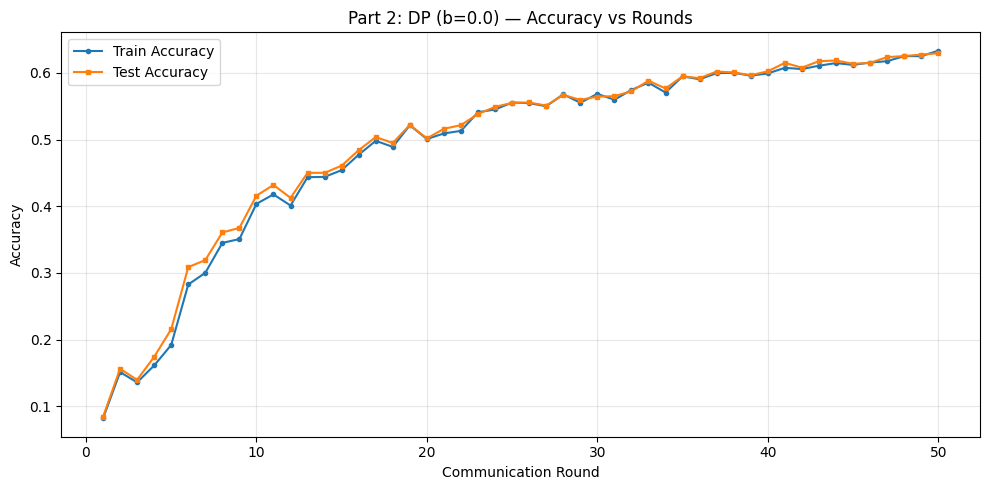

Saved: output/part2/part2_b000_loss.png


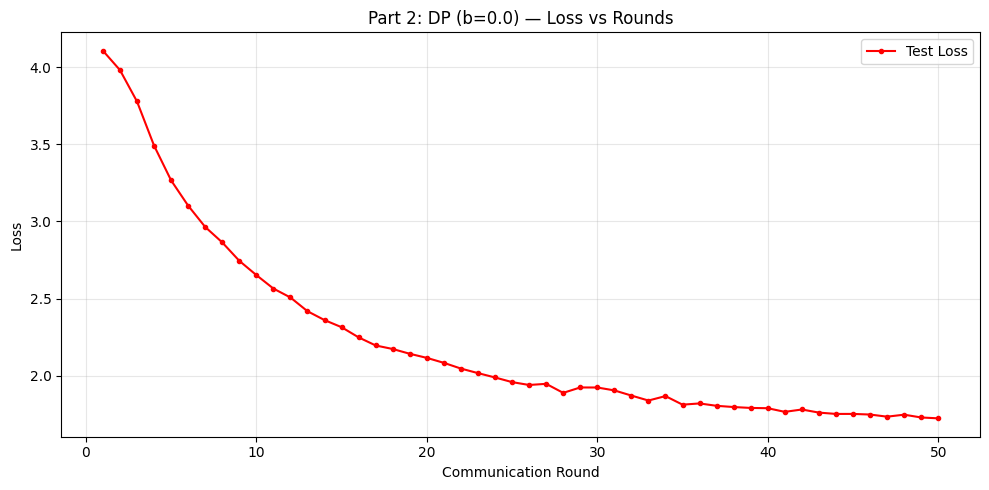


Training with noise scale b = 0.01
Applying Laplace noise with scale b=0.01 to all clients
[Round 001] train_acc=0.0222 test_acc=0.0301 loss=4.1248
[Round 002] train_acc=0.0583 test_acc=0.0834 loss=4.0463
[Round 003] train_acc=0.0577 test_acc=0.0773 loss=3.9018
[Round 004] train_acc=0.0578 test_acc=0.0989 loss=3.7858
[Round 005] train_acc=0.0600 test_acc=0.1477 loss=3.7292
[Round 006] train_acc=0.1318 test_acc=0.2276 loss=3.6636
[Round 007] train_acc=0.1382 test_acc=0.2408 loss=3.6105
[Round 008] train_acc=0.1073 test_acc=0.2486 loss=3.5995
[Round 009] train_acc=0.1470 test_acc=0.2610 loss=3.5000
[Round 010] train_acc=0.1411 test_acc=0.2831 loss=3.4669
[Round 011] train_acc=0.1492 test_acc=0.2665 loss=3.3783
[Round 012] train_acc=0.2041 test_acc=0.2936 loss=3.3494
[Round 013] train_acc=0.1284 test_acc=0.2745 loss=3.2776
[Round 014] train_acc=0.1900 test_acc=0.2980 loss=3.2080
[Round 015] train_acc=0.2003 test_acc=0.2969 loss=3.1806
[Round 016] train_acc=0.2543 test_acc=0.3093 loss=3.1

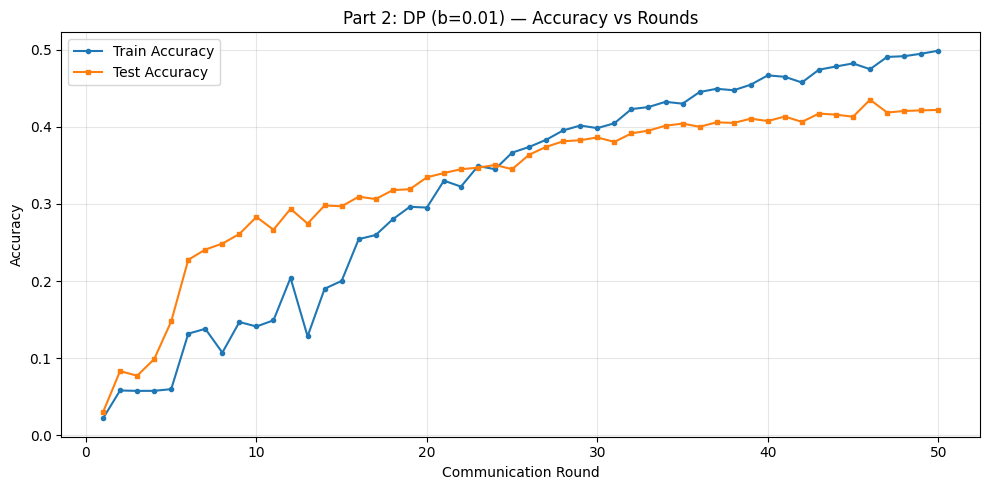

Saved: output/part2/part2_b000_loss.png


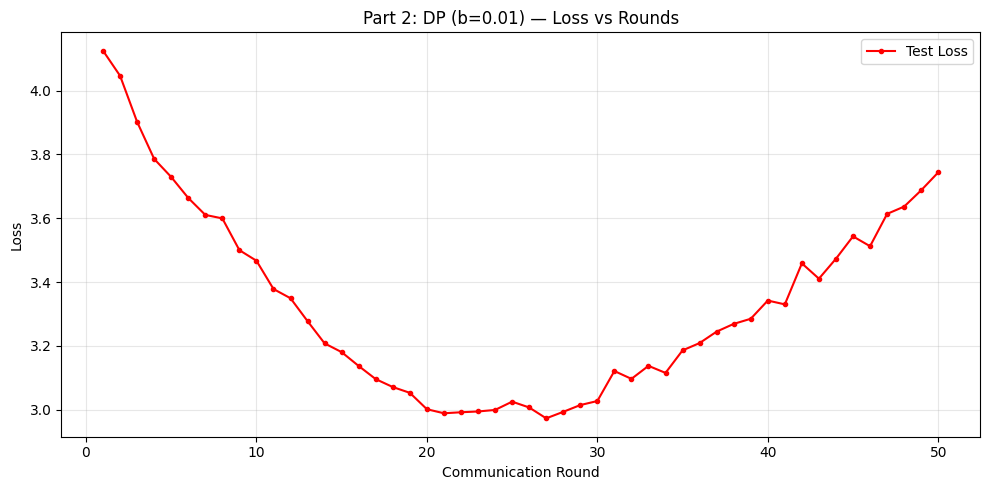


Training with noise scale b = 0.05
Applying Laplace noise with scale b=0.05 to all clients
[Round 001] train_acc=0.0222 test_acc=0.0326 loss=4.1250
[Round 002] train_acc=0.0577 test_acc=0.0845 loss=4.0479
[Round 003] train_acc=0.0577 test_acc=0.0795 loss=3.9117
[Round 004] train_acc=0.0580 test_acc=0.1000 loss=3.8074
[Round 005] train_acc=0.0584 test_acc=0.1417 loss=3.7525
[Round 006] train_acc=0.1288 test_acc=0.2342 loss=3.6938
[Round 007] train_acc=0.1328 test_acc=0.2439 loss=3.6429
[Round 008] train_acc=0.0977 test_acc=0.2508 loss=3.6305
[Round 009] train_acc=0.1482 test_acc=0.2618 loss=3.5304
[Round 010] train_acc=0.1436 test_acc=0.2889 loss=3.4938
[Round 011] train_acc=0.1502 test_acc=0.2729 loss=3.4025
[Round 012] train_acc=0.2097 test_acc=0.2958 loss=3.3745
[Round 013] train_acc=0.1291 test_acc=0.2737 loss=3.3022
[Round 014] train_acc=0.1955 test_acc=0.2944 loss=3.2270
[Round 015] train_acc=0.2031 test_acc=0.2925 loss=3.1860
[Round 016] train_acc=0.2581 test_acc=0.3085 loss=3.1

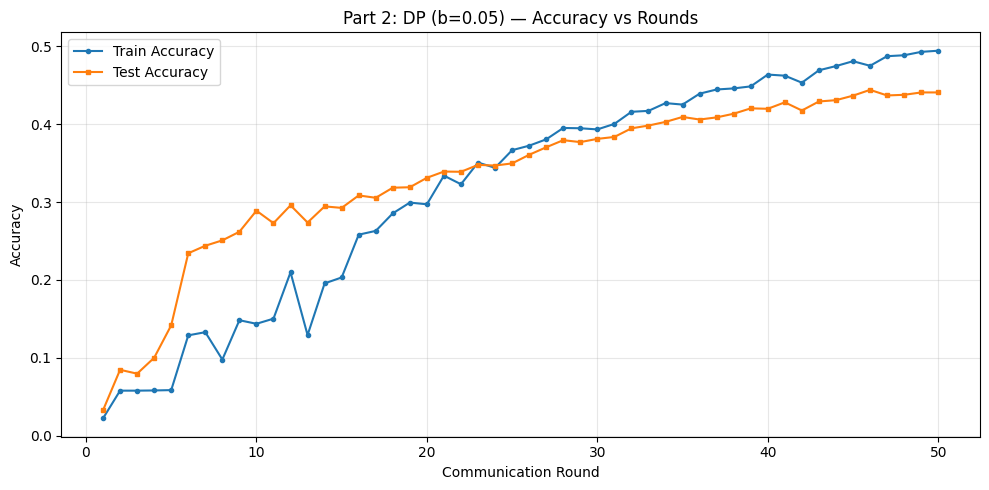

Saved: output/part2/part2_b000_loss.png


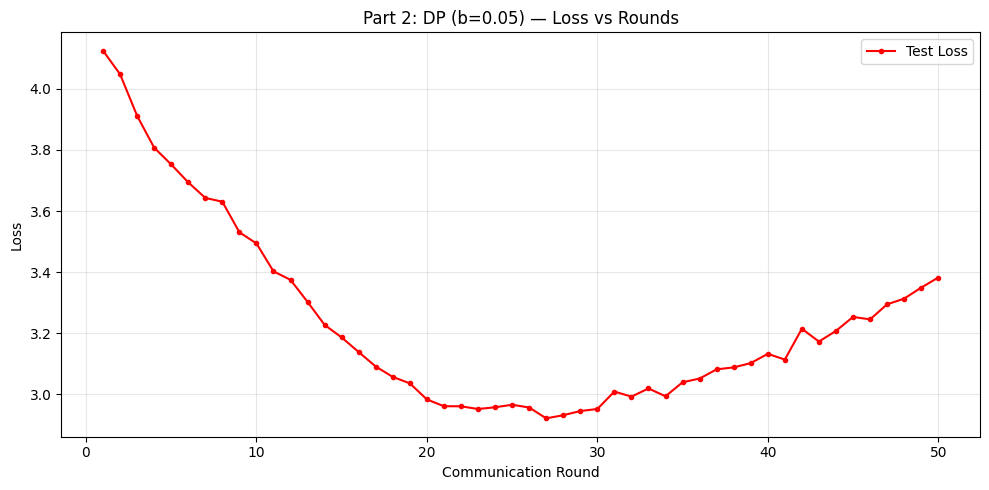


Training with noise scale b = 0.1
Applying Laplace noise with scale b=0.1 to all clients
[Round 001] train_acc=0.0222 test_acc=0.0304 loss=4.1249
[Round 002] train_acc=0.0577 test_acc=0.0834 loss=4.0510
[Round 003] train_acc=0.0577 test_acc=0.0793 loss=3.9226
[Round 004] train_acc=0.0602 test_acc=0.1232 loss=3.8322
[Round 005] train_acc=0.0606 test_acc=0.1701 loss=3.7769
[Round 006] train_acc=0.1434 test_acc=0.2317 loss=3.7177
[Round 007] train_acc=0.1305 test_acc=0.2347 loss=3.6686
[Round 008] train_acc=0.1137 test_acc=0.2494 loss=3.6562
[Round 009] train_acc=0.1456 test_acc=0.2579 loss=3.5555
[Round 010] train_acc=0.1438 test_acc=0.2753 loss=3.5211
[Round 011] train_acc=0.1467 test_acc=0.2621 loss=3.4268
[Round 012] train_acc=0.2076 test_acc=0.2875 loss=3.4013
[Round 013] train_acc=0.1263 test_acc=0.2693 loss=3.3324
[Round 014] train_acc=0.1922 test_acc=0.2845 loss=3.2552
[Round 015] train_acc=0.2049 test_acc=0.2856 loss=3.2084
[Round 016] train_acc=0.2512 test_acc=0.2961 loss=3.161

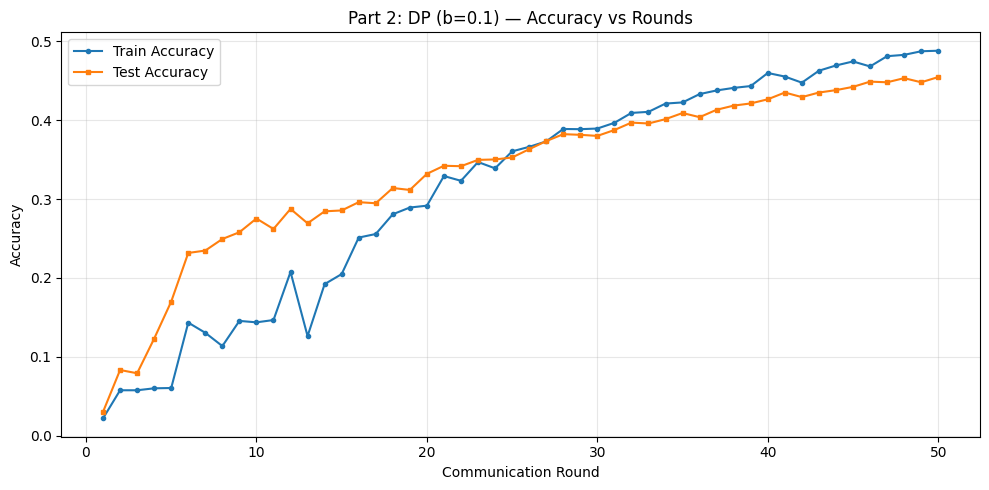

Saved: output/part2/part2_b000_loss.png


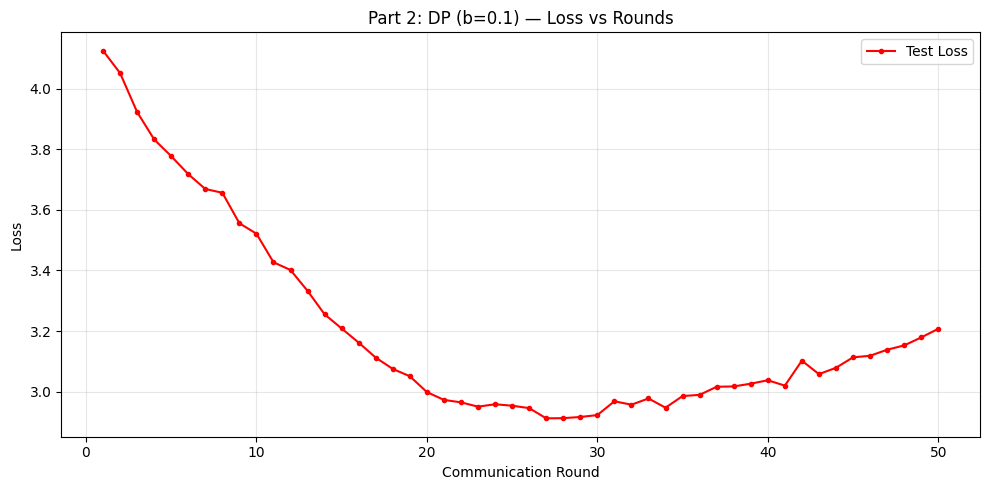

In [14]:
# Run Part 2: Differential Privacy experiments
print(f"\n{'='*60}")
print("Part 2: Differential Privacy with Laplace Noise")
print(f"{'='*60}")

# Store results for all noise scales
dp_results = {}

for noise_scale in Config.noise_scales:
    print(f"\n{'='*60}")
    print(f"Training with noise scale b = {noise_scale}")
    print(f"{'='*60}")
    
    # Reload and preprocess data (to avoid modifying original)
    clients_dp = load_clients_from_npy(Config.train_data_path)
    Xte_dp, yte_dp = load_test_from_npy(Config.test_data_path)
    clients_dp, yte_dp, n_classes_dp, _ = remap_labels_global(clients_dp, yte_dp)
    
    if Config.standardize:
        clients_dp, Xte_dp = standardize_train_test(clients_dp, Xte_dp)
    else:
        clients_dp = to_float_clients(clients_dp)
        Xte_dp = to_float_test(Xte_dp)
    
    # Train with noise
    history_dp, state_dp, best_acc_dp = train_fedavg_serial(
        clients=clients_dp,
        Xte=Xte_dp,
        yte=yte_dp,
        n_classes=n_classes_dp,
        in_dim=in_dim,
        rounds=Config.rounds,
        client_frac=Config.client_frac,
        local_epochs=Config.local_epochs,
        batch_size=Config.batch_size,
        lr=Config.lr,
        optimizer=Config.optimizer,
        weight_decay=Config.weight_decay,
        label_smoothing=Config.label_smoothing,
        hidden=Config.hidden_layers,
        dropout=Config.dropout,
        use_bn=Config.use_bn,
        device=device,
        seed=42,
        noise_scale=noise_scale
    )
    
    dp_results[noise_scale] = {
        'history': history_dp,
        'best_acc': best_acc_dp,
        'final_acc': history_dp[-1]['test_acc'] if history_dp else 0.0
    }
    
    # Plot individual results
    plot_training_history(
        history_dp, 
        title_prefix=f"Part 2: DP (b={noise_scale})",
        save_path=f"{Config.part2_dir}/part2_b{noise_scale:03.0f}"
    )


### 5.3 Privacy-Utility Tradeoff Analysis


Saved: output/part2/part2_dp_final_acc_vs_b.png


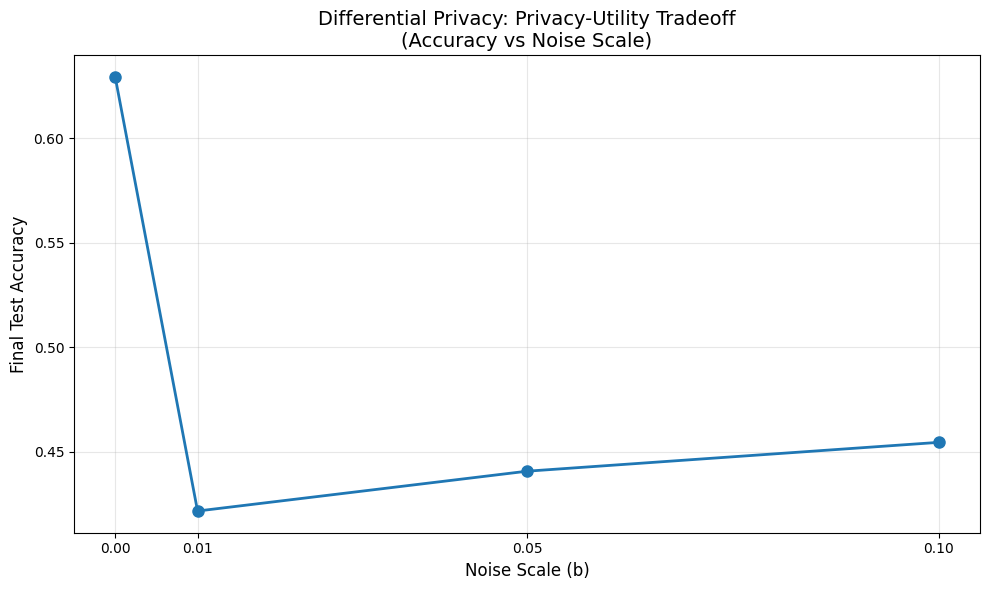


Differential Privacy Results Summary
Noise Scale (b)      Final Accuracy       Best Accuracy       
------------------------------------------------------------
0.0000               0.6294               0.6294              
0.0100               0.4217               0.4350              
0.0500               0.4408               0.4441              
0.1000               0.4546               0.4546              


In [15]:
# Plot accuracy vs noise scale (privacy-utility tradeoff)
noise_scales_sorted = sorted(dp_results.keys())
final_accs = [dp_results[b]['final_acc'] for b in noise_scales_sorted]

plt.figure(figsize=(10, 6))
plt.plot(noise_scales_sorted, final_accs, marker='o', markersize=8, linewidth=2)
plt.xlabel('Noise Scale (b)', fontsize=12)
plt.ylabel('Final Test Accuracy', fontsize=12)
plt.title('Differential Privacy: Privacy-Utility Tradeoff\n(Accuracy vs Noise Scale)', fontsize=14)
plt.grid(True, alpha=0.3)
plt.xticks(noise_scales_sorted)
plt.tight_layout()
plt.savefig(f"{Config.part2_dir}/part2_dp_final_acc_vs_b.png", dpi=160, bbox_inches="tight")
print(f"Saved: {Config.part2_dir}/part2_dp_final_acc_vs_b.png")
plt.show()

# Print summary table
print("\n" + "="*60)
print("Differential Privacy Results Summary")
print("="*60)
print(f"{'Noise Scale (b)':<20} {'Final Accuracy':<20} {'Best Accuracy':<20}")
print("-"*60)
for b in noise_scales_sorted:
    final = dp_results[b]['final_acc']
    best = dp_results[b]['best_acc']
    print(f"{b:<20.4f} {final:<20.4f} {best:<20.4f}")
print("="*60)


## 6. Additional Utilities

### 6.1 Save History to CSV


In [16]:
def save_history_to_csv(history, filepath):
    """Save training history to CSV file."""
    os.makedirs(os.path.dirname(filepath) if os.path.dirname(filepath) else '.', exist_ok=True)
    with open(filepath, "w", newline="") as f:
        writer = csv.DictWriter(f, fieldnames=["round", "train_acc", "test_acc", "loss"])
        writer.writeheader()
        for row in history:
            writer.writerow(row)
    print(f"Saved history to {filepath}")

# Example: Save Part 1 history
save_history_to_csv(history_part1, f"{Config.part1_dir}/part1_history.csv")

# Example: Save Part 2 histories
for noise_scale in Config.noise_scales:
    if noise_scale in dp_results:
        save_history_to_csv(
            dp_results[noise_scale]['history'],
            f"{Config.part2_dir}/part2_b{noise_scale:03.0f}_history.csv"
        )


Saved history to output/part1/part1_history.csv
Saved history to output/part2/part2_b000_history.csv
Saved history to output/part2/part2_b000_history.csv
Saved history to output/part2/part2_b000_history.csv
Saved history to output/part2/part2_b000_history.csv


### 6.2 Model Evaluation (Confusion Matrix)


Evaluating Part 1 model:
Final Test Accuracy: 0.6294


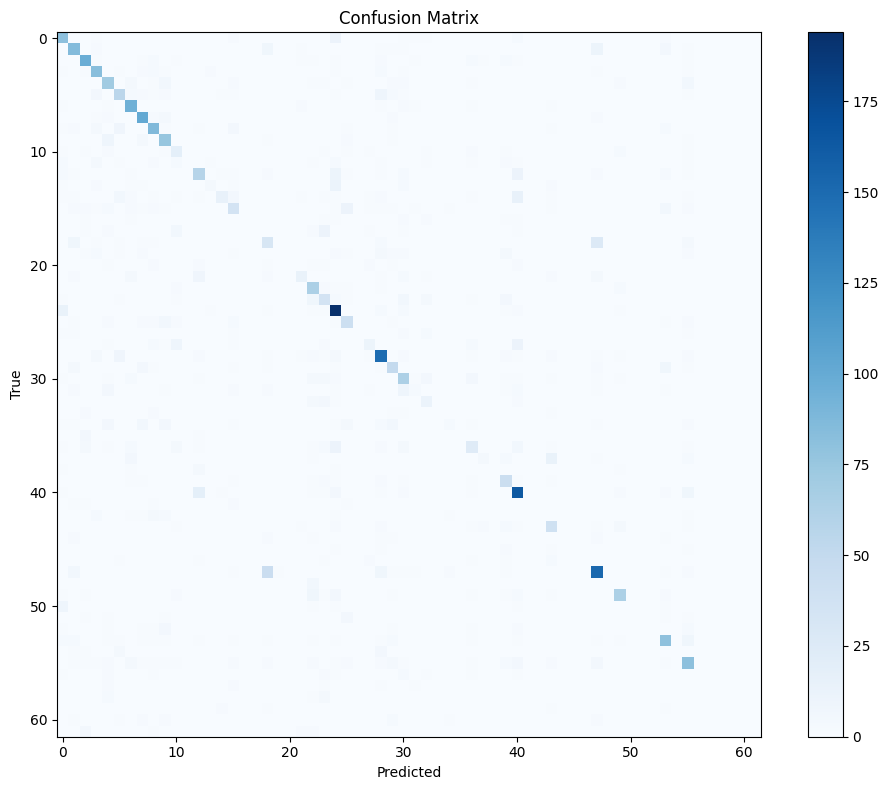


Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.79      0.70       103
           1       0.69      0.75      0.71       114
           2       0.78      0.82      0.80       118
           3       0.72      0.82      0.76       101
           4       0.60      0.71      0.65       100
           5       0.62      0.65      0.63        85
           6       0.73      0.90      0.81       105
           7       0.75      0.89      0.81       114
           8       0.71      0.76      0.73       115
           9       0.64      0.81      0.72        94
          10       0.35      0.53      0.42        34
          11       0.00      0.00      0.00        25
          12       0.59      0.59      0.59        99
          13       0.50      0.15      0.23        27
          14       0.75      0.26      0.39        57
          15       0.49      0.47      0.48        75
          16       0.00      0.00      0.00        10
   

In [17]:
def evaluate_model_detailed(model, Xte, yte, n_classes, device, batch_size=1024):
    """Evaluate model and generate confusion matrix and classification report."""
    model.eval()
    loader = make_loader(Xte, yte, batch_size, shuffle=False, drop_last=False)
    
    all_preds, all_true = [], []
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device)
            yb = yb.to(device)
            logits = model(xb)
            preds = logits.argmax(dim=1)
            all_preds.append(preds.cpu().numpy())
            all_true.append(yb.cpu().numpy())
    
    y_pred = np.concatenate(all_preds)
    y_true = np.concatenate(all_true)
    
    acc = (y_pred == y_true).mean()
    print(f"Final Test Accuracy: {acc:.4f}")
    
    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=np.arange(n_classes))
    plt.figure(figsize=(10, 8))
    plt.imshow(cm, interpolation="nearest", cmap='Blues')
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.colorbar()
    plt.tight_layout()
    plt.show()
    
    # Classification report
    report = classification_report(y_true, y_pred, labels=np.arange(n_classes), zero_division=0)
    print("\nClassification Report:")
    print(report)
    
    return acc, cm, report

# Example: Evaluate Part 1 model
print("Evaluating Part 1 model:")
model_part1 = MLP(in_dim=in_dim, hidden=Config.hidden_layers, out_dim=n_classes, 
                  dropout=Config.dropout, use_bn=Config.use_bn).to(device)
model_part1.load_state_dict(global_state_part1, strict=True)
acc_part1, cm_part1, report_part1 = evaluate_model_detailed(model_part1, Xte, yte, n_classes, device)


## Summary

This notebook combines all code for:
- **Part 1**: Federated Learning (FedAvg) - both serial and Ray-based implementations
- **Part 2**: Differential Privacy experiments with Laplace noise

### Key Features:
1. **Data Loading**: Robust loading of federated EMNIST data from .npy files
2. **Preprocessing**: Label remapping, standardization, normalization
3. **Model**: Configurable MLP with batch normalization and dropout
4. **FedAvg**: Serial and parallel (Ray) implementations
5. **Differential Privacy**: Laplace noise addition and privacy-utility analysis
6. **Visualization**: Training curves, label histograms, confusion matrices
7. **Utilities**: CSV export, model evaluation, plotting functions

### Outputs:
- Training history plots (accuracy/loss vs rounds)
- Label distribution histograms
- Privacy-utility tradeoff plots
- Confusion matrices
- CSV logs of training history

All outputs are saved to `output/part1/` and `output/part2/` directories.
